In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase
using NFFT
using CSV
using FHist
using Plots
using Random, Distributions, SpecialFunctions, LsqFit

In [3]:
function introduction(p, S; arr=1:100)
    q, r = rand(S), rand(arr,S)
    out = zeros(S)
    out[q .> p] .= r[q .> p]
    return out
end;

In [199]:
Random.seed!(1234)

# Set parameters
S = 5000
y0 = 100 .* ones(S)
Δt = 0.1
n = 450
p = 0.96

# Simulate discrete dynamics
y = zeros(n,S)
y[1,:] .= y0
for i in 2:n
    gamma = abs.(1 .+ rand(Normal(0, 0.5), S))
    growth = y[i-1,:] .* exp.(log.(gamma) .* Δt)
    intro = introduction(p,S,arr=1:100)
    y[i,:] = growth .+ intro
end

# Normalize entries
y ./= sum(y, dims=2)

# Save results into a DataFrame
n, S = size(y)
df = DataFrame(
    time = repeat(1:n, inner=S),
    variable = repeat(1:S, outer=n),
    value = vec(permutedims(y)),
    log_value = vec(permutedims(log10.(y)))
)

df_filtered = df[df.value .> 0.0, :];

450
450


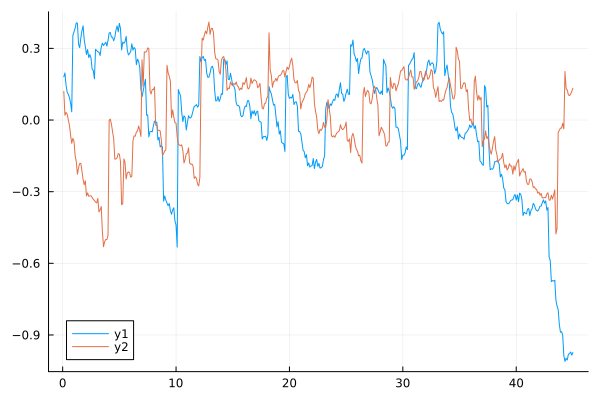

In [200]:
ddf = sort(df_filtered, :time);
idx1, idx2 = 1, 20

ts1 = ddf[ddf.variable .== ddf.variable[idx1],:].log_value
ts2 = ddf[ddf.variable .== ddf.variable[idx2],:].log_value

ts1 .-= mean(ts1)
ts2 .-= mean(ts2)

times1 = ddf[ddf.variable .== ddf.variable[idx1],:].time .* Δt
times2 = ddf[ddf.variable .== ddf.variable[idx2],:].time .* Δt

println(length(times1))
println(length(times2))

plot(times1, ts1)
plot!(times2, ts2)

In [201]:
function window_correction(window)
    # Helper function to avoid odd number of time steps which creates problems for FFT
    while (maximum(window) - minimum(window)) % 2 != 0
        if length(window) <= 1
            break  # Can't reduce further
        end
        window = window[1:end-1]  # Remove the last element
    end
    return window
end

function consecutive_window(data::Vector{<:Integer}, n::Integer = 0)
    if isempty(data)
        return Integer[]
    end
    out1 = [data[1]]
    out2 = Integer[]
    for (i, d) in enumerate(data[2:end])
        if d - out1[end] <= n + 1
            push!(out1, d)
        else
            out2 = consecutive_window(data[i+1:end], n)
            break
        end
    end
    return length(out1) >= length(out2) ? window_correction(out1) : window_correction(out2)
end

# Find the largest time window considering a maximum gap of 'daygap' days
daygap = 3
unique_days = unique(df_filtered.time)
sort!(unique_days)
window = consecutive_window(unique_days, daygap)
println(length(window))

# Filter to consider only rows with experiment_day in the selected window and reorder them
df_subset = filter(row -> in(row.time, window), df_filtered)
sort!(df_subset, :time);

449


In [202]:
# Set paramas and variables to perform NFFT
N = Int64(maximum(window) - minimum(window))
N_min = N / 2 # The analysis will consider only those species that are present in a 'sufficient' number of samples
fs = 1 / Δt
Nf = fs / 2 # Since sample rate is 1 day
frequencies = (-Int(floor(N/2)):Int(floor(N/2) - 1)) * fs / N # Frequency domain

println("Window length:  $N")

mean_S = zeros(N) # Initialize array
otu_count = 0 # Needed for normalization
otu_ids = unique(df_subset.variable)[1:200]
df_filtered = filter(:variable => in(otu_ids), df_subset)
grouped = groupby(df_filtered, :variable)

for otu in otu_ids
    group = grouped[otu]

    t_indices = collect(group.time)
    t_normalized = (t_indices .- minimum(window)) ./ N .- 0.5

    x = collect(group.log_value)
    x .-= mean(x)

    if length(t_indices) > N_min
        otu_count += 1
        p_nfft = NFFT.plan_nfft(t_normalized, N, reltol=1e-9)
        fhat = adjoint(p_nfft) * x

        S = abs2.(fhat) .* (Δt / N)
        mean_S .+= S
    end
end

println("OTUs considered:  $otu_count")

# Take only positive frequencies
positive = frequencies .> 0
frequencies = frequencies[positive]
mean_S = mean_S[positive] ./ otu_count;

Window length:  448
OTUs considered:  200


Estimated slope: -1.918992316267839
Intercept: -2.99249753357133


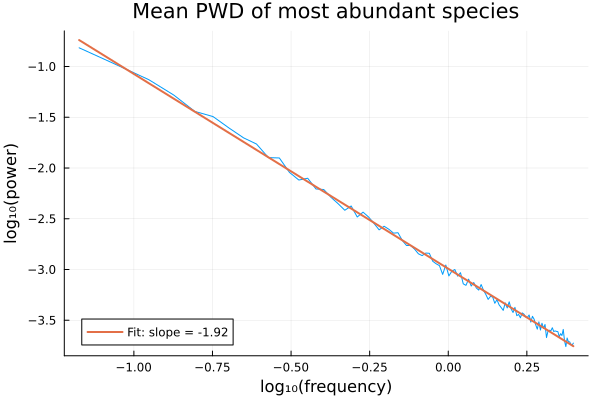

In [203]:
# # Take logs
log_f = log10.(frequencies)
log_S = log10.(mean_S)

# Filter frequencies to avoid bias at too low and too high frequencies
# Essentially the fact the we have linear frequency binning but we compute the slope in log-log space creates problems
# at very low freqs because there are less points and at very high freqs because there are too many points. Moreover these
# methods are exact only in the infinite time case so we need to consider border effects.
mask = (log_f .> -1.3) .& (log_f .< 0.4)
log_f = log_f[mask]
log_S = log_S[mask]

# Put into a DataFrame and fit linear model: log_S ~ log_k
plot_df = DataFrame(log_f=log_f, log_S=log_S)
model = lm(@formula(log_S ~ log_f), plot_df)

# Extract the slope and intercept
coeffs = coef(model)
slope = coeffs[2]
intercept = coeffs[1]

println("Estimated slope: ", slope)
println("Intercept: ", intercept)

# Plot results
plot(log_f, log_S, label=:none, xlabel="log₁₀(frequency)", ylabel="log₁₀(power)", legend=:bottomleft,
    title="Mean PWD of most abundant species")
plot!(log_f, predict(model), label="Fit: slope = $(round(slope, digits=2))", lw=2)

In [204]:
# Consider only last point in time
new_df = df_subset[df_subset.time .== maximum(df_subset.time), :]
data = new_df.value
log_data = new_df.log_value;

α = 2.157359007770592
β = 2.140506516850343
θ = 0.5818665808433965
s = 1.7274026302756684
s_th = 2.2961149626090624


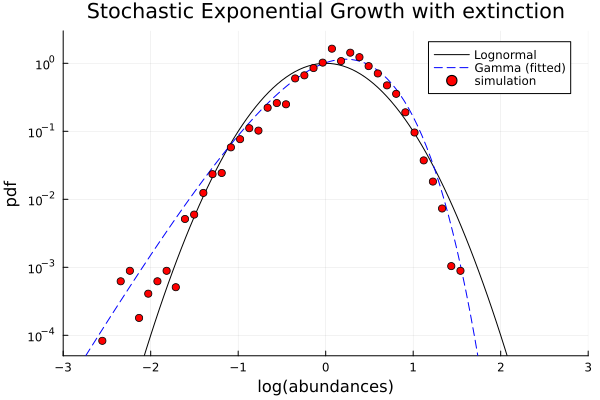

In [209]:
bmin = round(minimum(log_data), RoundFromZero)
bmax = round(maximum(log_data), RoundFromZero)
Δb = 0.05
fh = FHist.Hist1D(log_data, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
y = [10^log(norm_counts[norm_counts.>0.0][i] .* sqrt(2 * π * σ^2)) for i in eachindex(norm_counts[norm_counts.>0.0])]
centers = centers[norm_counts.>0.0]

# Plot the Gaussian distribution
xarr = -3.0:0.05:3.0
func = [10^(-x^2) for x in xarr]
plot(xarr, func, color=:black, label="Lognormal", yscale=:log10, yrange=(5e-5, 3), xrange=(-3, 3),
    title="Stochastic Exponential Growth with extinction", xlabel="log(abundances)", ylabel="pdf")

# Fit and plot gamma function
exp_gamma(x, p) = p[1] .* x .+ p[2] .* exp.(x) .+ p[3]
p0 = [2.0, 1.0, 1.0]  # Initial guess for the parameters
fit = curve_fit(exp_gamma, centers, log.(norm_counts[norm_counts.>0.0]), p0)
p_fit = fit.param

α, θ, s = p_fit[1], -1/p_fit[2], p_fit[3]
s_th = -(loggamma(α) + α * log(abs(θ))) / sqrt(2 * σ^2)
β = mean(data)^2 / var(data)
println("α = $α")
println("β = $β")
println("θ = $θ")
println("s = $s")
println("s_th = $s_th")

xarr = -3.0:0.05:3.0
fitted_y = exp_gamma(xarr, p_fit)
exp_fitted_y = [10^fy for fy in fitted_y]
plot!(xarr, exp_fitted_y, color=:blue, label="Gamma (fitted)", linestyle=:dash)

# Plot the collective histogram as a scatter plot
scatter!(centers, y, color=:red, label="simulation")
# savefig("./Images/exp_growth.png")